In [510]:
import statsapi
import pandas as pd
from datetime import date, timedelta
import time
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.cluster import KMeans




In [132]:
def movingAverage(numGames, l):
    movingAverages = []
    n = len(l)

    for i in range(n):
        if i + 1 < numGames:
            movingAverages.append(np.mean(l[:i+1]))
        else:
            window = l[i+1-numGames:i+1]
            movingAverages.append(np.mean(window))
    
    return movingAverages
def getGamesPlayed(player_name):
    player_id = statsapi.lookup_player(player_name)[0]['id']
    time.sleep(0.2)

    stats = statsapi.player_stat_data(player_id, group='hitting', type='season', season = 2025)['stats']
    time.sleep(0.2)

    
    if stats and stats[0]['stats'].get('gamesPlayed'):
        return int(stats[0]['stats']['gamesPlayed'])
    else:
        return 0  
    


def getHitters(team_id):
    roster = statsapi.get('team_roster', {'teamId': team_id, 'rosterType': 'active'})
    time.sleep(0.2)

    hitters = []
    for player in roster['roster']:
        position = player['position']['abbreviation']
        
        if position != 'P':  # 'P' = Pitcher
            name = player['person']['fullName']
            player_id = player['person']['id']
            hitters.append(name)
    
    return hitters

def get_game_log_real(player_name):
    
    player_id = statsapi.lookup_player(player_name)[0]['id']
    time.sleep(0.2)
    data = statsapi.get("person", {
        "personId": player_id,
        "hydrate": "stats(group=[hitting],type=[gameLog], season = 2025)"
    })
    time.sleep(0.2)
    try:
        splits = data['people'][0]['stats'][0]['splits']
    except (KeyError, IndexError):
        raise ValueError("No game log data found.")

    rows = []
    for game in splits:
        date = pd.to_datetime(game['date'])
        stat = game['stat']
        bases = int(stat.get('totalBases', 0))
        walks = int(stat.get('baseOnBalls', 0))
        runs = int(stat.get('runs', 0))
        rbi = int(stat.get('rbi', 0))
        sb = int(stat.get('stolenBases', 0))
        k = int(stat.get('strikeOuts', 0))
        fantasyPoints = bases + walks + runs + rbi + sb - k
        
        rows.append({'Date': date, f'{player_name}': fantasyPoints})
        
    df =  pd.DataFrame(rows)
    df[f'{player_name} 10 Day MA'] = movingAverage(10, list(df[player_name]))
    df.drop(columns = [player_name], inplace = True)
    
    return df

def getTeamDF(teamnumber):
    dfs = []
    dfTeam = pd.DataFrame({
            'Name': list(getHitters(teamnumber)),
        })
    
    time.sleep(0.2)

    dfTeam['Games Played'] = dfTeam['Name'].apply(getGamesPlayed)
    dfTeam = dfTeam[dfTeam['Games Played'] > 90]
    Hitters = list(dfTeam['Name'])

    for player in Hitters:
        dfs.append(get_game_log_real(player))
    
        teamDF = reduce(lambda x, y: pd.merge(x, y, on = 'Date'), dfs)
    teamDF['Sum'] = teamDF.select_dtypes(include='number').sum(axis=1)
    teamDF['10 Day Ma : Sum'] = movingAverage(10, teamDF['Sum'])
    teamDF.drop(columns = ['Sum'] , inplace = True)
    return teamDF
    

def getTeamDFSum(teamnumber):
    dfs = []
    dfTeam = pd.DataFrame({
            'Name': list(getHitters(teamnumber)),
        })
    
    dfTeam['Games Played'] = dfTeam['Name'].apply(getGamesPlayed)
    dfTeam = dfTeam[dfTeam['Games Played'] > 90]
    Hitters = list(dfTeam['Name'])

    for player in Hitters:
        dfs.append(get_game_log_real(player))
    
        teamDF = reduce(lambda x, y: pd.merge(x, y, on = 'Date'), dfs)
    teamDF['Sum'] = teamDF.select_dtypes(include='number').sum(axis=1)
    teamDF['10 Day Ma : Sum'] = movingAverage(10, teamDF['Sum'])
    teamDF.drop(columns = ['Sum'] , inplace = True)
    return teamDF[['Date','10 Day Ma : Sum']]
    



In [104]:

def getPitchingLog(player_name: str) -> pd.DataFrame:
    people = statsapi.lookup_player(player_name)
    if not people:
        raise ValueError(f"Player '{player_name}' not found")

    player_id = people[0]['id']

    data = statsapi.get("person", {
        "personId": player_id,
        "hydrate": "stats(group=[pitching],type=[gameLog], season = 2025)"
    })

    people_block = data.get('people', [])
    if not people_block:
        raise ValueError(f"No 'people' block returned for {player_name}")

    stats_blocks = people_block[0].get('stats', [])
    if not stats_blocks:
        raise ValueError(f"No pitching stats block found for {player_name} (is he a pitcher / has logs?)")

    splits = stats_blocks[0].get('splits', [])
    if not splits:
        raise ValueError(f"No game log data found for {player_name}")

    def _safe_int(x, default=0):
        try:
            return int(x)
        except Exception:
            return default

    def _ip_to_float(ip_str: str) -> float:
        # MLB IP format uses .1 = 1/3, .2 = 2/3
        whole, _, frac = str(ip_str).partition('.')
        outs = _safe_int(whole, 0) * 3 + (_safe_int(frac, 0) if frac else 0)
        return outs / 3.0

    rows = []
    running = []

    for g in splits:
        stat = g.get('stat', {}) or {}

        ip     = _ip_to_float(stat.get('inningsPitched', '0'))
        er     = _safe_int(stat.get('earnedRuns',   0))
        wins   = _safe_int(stat.get('wins',         0))
        losses = _safe_int(stat.get('losses',       0))
        saves  = _safe_int(stat.get('saves',        0))
        holds  = _safe_int(stat.get('holds',        0))
        k      = _safe_int(stat.get('strikeOuts',   0))
        hits   = _safe_int(stat.get('hits',         0))
        walks  = _safe_int(stat.get('baseOnBalls',  0))

        fantasy = 3*ip + 5*wins - 5*losses + 5*saves + 3*holds + 1*k - 2*er - 1*hits - 1*walks

        running.append(fantasy)
        rolling_mean = round(sum(running) / len(running), 2) =

        rows.append({
            'Date': pd.to_datetime(g.get('date')),
            player_name: fantasy,
            f'{player_name} Rolling Mean': rolling_mean
        })

    df = pd.DataFrame(rows).sort_values('Date').reset_index(drop=True)
    return df



def getPitchingMean(player_name):
    df =   getPitchingLog(player_name)
    mean =   df[player_name].mean()
    time.sleep(1)
    return mean 
    
def getPitchingVol(player_name):
    df =   getPitchingLog(player_name)
    vol =  df[player_name].std()
    time.sleep(1)
    return vol


In [106]:
def getPitchers(team_id):
    roster = statsapi.get('team_roster', {'teamId': team_id, 'rosterType': 'active'})
    
    pitchers = []
    for player in roster['roster']:
        position = player['position']['abbreviation']
        
        if 'P' in position:  # 'P' = Pitcher
            name = player['person']['fullName']
            position = player['position']['abbreviation']
            pitchers.append(name)
    
    return pitchers

In [620]:
def baseline_mean_from_plog(p_log: pd.DataFrame, game_date: str, name: str, min_games: int = 5) -> float:
    df = p_log.copy()
    df['Date'] = pd.to_datetime(df['Date']).dt.normalize()
    gd = pd.to_datetime(game_date).normalize()

    prior = df[df['Date'] < gd].sort_values('Date')
    if prior.empty:
        return None  

    if len(prior) >= min_games:
        return float(prior[name].tail(min_games).mean())
    else:
        return float(prior[name].mean())



def compare_change_and_pitcher_perf(team_id):
    df = getTeamDFSum(team_id).reset_index(drop=True)
    
    df["Change_5"] = df["10 Day Ma : Sum"].diff(periods=5)
    
    results = []
    
    for i in range(15, len(df)):
        game_date = df.loc[i, "Date"]
        change_5 = df.loc[i, "Change_5"]

        opp_pitcher_name = get_opposing_pitcher(team_id, game_date)
        
        if not opp_pitcher_name:
            continue
        
        p_log = getPitchingLog(opp_pitcher_name)  
        Nmean =  p_log[opp_pitcher_name].mean() 
        std = round(p_log[opp_pitcher_name].std() , 2)
         
        
        
        results.append({
            "Date": game_date,
            "Team_Change_5": change_5,
            "Pitcher": opp_pitcher_name,
            "Pitcher_SeasonMean": Nmean,
            "Vol" : std
        })
    
    return pd.DataFrame(results)


def get_opposing_pitcher(team_id, game_date):

    d = pd.to_datetime(game_date).strftime("%Y-%m-%d")

    sched = statsapi.schedule(team=team_id, start_date=d, end_date=d)
    if not sched:
        return None

    def _game_rank(g):
        status = g.get("status")
        is_final = 1 if (status and "Final" in status) else 0
        return (-is_final, g.get("game_datetime", g.get("game_date")))

    game = sorted(sched, key=_game_rank)[0]

    home_id = game["home_id"]; away_id = game["away_id"]
    side = "home" if home_id == team_id else "away"
    opp_side = "away" if side == "home" else "home"

    probable_key = f"{opp_side}_probable_pitcher"
    name = game.get(probable_key)

    if name:  
        return name

    game_pk = game["game_id"]
    g = statsapi.get("game", {"gamePk": game_pk})
    opp_block = g["liveData"]["boxscore"]["teams"][opp_side]

    pids = opp_block.get("pitchers", [])
    starter_id = pids[0] if pids else None
    if starter_id is None:
        for pdata in opp_block.get("players", {}).values():
            st = pdata.get("stats", {}).get("pitching", {})
            try:
                if int(st.get("gamesStarted", 0)) == 1:
                    starter_id = pdata["person"]["id"]
                    break
            except Exception:
                pass

    if starter_id is None:
        return None

    for pdata in opp_block.get("players", {}).values():
        if pdata["person"]["id"] == starter_id:
            return pdata["person"]["fullName"]

    return None

In [ ]:
dfPhils = compare_change_and_pitcher_perf(141)
dfPhils

In [ ]:
Pitchers["Pitcher"] = Pitchers.index
Pitchers["Season Mean"] = Pitchers["Pitcher"].apply(getPitchingMean)


In [189]:
kmeans = KMeans(n_clusters = 3)
kmeans.fit(Pitchers[["Season Mean" , "Vol" ]])
Pitchers['kmeans label'] = kmeans.labels_

In [195]:
Pitchers["FP Ratio"] = (Pitchers["Season Mean"] / Pitchers["Vol"]).round(2)

In [235]:
Pitchers

,Team_Change_5,Pitcher_SeasonMean,Vol,Pitcher,Season Mean,kmeans label,FP Ratio
Pitcher,,,,,,,
AJ Smith-Shawver,0.712698,4.166667,14.22,AJ Smith-Shawver,8.777778,0,0.62
Aaron Bummer,-0.605000,3.500000,4.67,Aaron Bummer,2.153846,2,0.46
Aaron Civale,-1.530000,0.270000,12.94,Aaron Civale,5.600000,0,0.43
Aaron Nola,-0.485000,7.100000,14.28,Aaron Nola,3.111111,0,0.22
Adrian Houser,-1.037500,15.292857,11.97,Adrian Houser,11.307692,1,0.94
...,...,...,...,...,...,...,...
Zac Gallen,0.205551,6.333333,13.52,Zac Gallen,7.500000,0,0.55
Zach Eflin,-0.283000,8.510000,15.11,Zach Eflin,5.285714,0,0.35
Zack Littell,-0.162198,11.115000,9.62,Zack Littell,10.875000,1,1.13


In [303]:
def pitcherType( kmean):
    if kmean == 0:
        return "Streamer"
    elif kmean == 1:
        return "Ace"
    elif kmean == 2:
        return "Trash"
    else:
        return "NA"
Pitchers["Type"] = Pitchers["kmeans label"].apply(pitcherType)
Pitchers.index = list(range(0,len(Pitchers["Type"])))
Pitchers

,Team_Change_5,Pitcher_SeasonMean,Vol,Pitcher,Season Mean,kmeans label,FP Ratio,Type
0,0.712698,4.166667,14.22,AJ Smith-Shawver,8.777778,0,0.62,Streamer
1,-0.605000,3.500000,4.67,Aaron Bummer,2.153846,2,0.46,Trash
2,-1.530000,0.270000,12.94,Aaron Civale,5.600000,0,0.43,Streamer
3,-0.485000,7.100000,14.28,Aaron Nola,3.111111,0,0.22,Streamer
4,-1.037500,15.292857,11.97,Adrian Houser,11.307692,1,0.94,Ace
...,...,...,...,...,...,...,...,...
265,0.205551,6.333333,13.52,Zac Gallen,7.500000,0,0.55,Streamer
266,-0.283000,8.510000,15.11,Zach Eflin,5.285714,0,0.35,Streamer
267,-0.162198,11.115000,9.62,Zack Littell,10.875000,1,1.13,Ace
268,0.526543,20.444444,11.42,Zack Wheeler,18.608696,1,1.63,Ace


In [211]:
means = pd.DataFrame(Pitchers.groupby("kmeans label").mean(numeric_only = True))
means

,Team_Change_5,Pitcher_SeasonMean,Vol,Season Mean,FP Ratio
kmeans label,,,,,
0,-0.219062,7.291531,12.051376,6.609480,0.579292
1,-0.074671,13.603529,10.675712,13.354954,1.382368
2,-0.327529,2.566408,6.428510,2.416896,0.510494


[Text(0.5, 1.0, 'Mean Vol Frontier MLB Pitchers 2025\nn=270\nUsed K-Means to seperate the data into three groups\nPattern is opposite of the mean-variance frontier (Finance)'),
 Text(0, 0.5, 'Mean Fantasy Points / Week'),
 Text(0.5, 0, 'Volatility of Fantasy Points')]

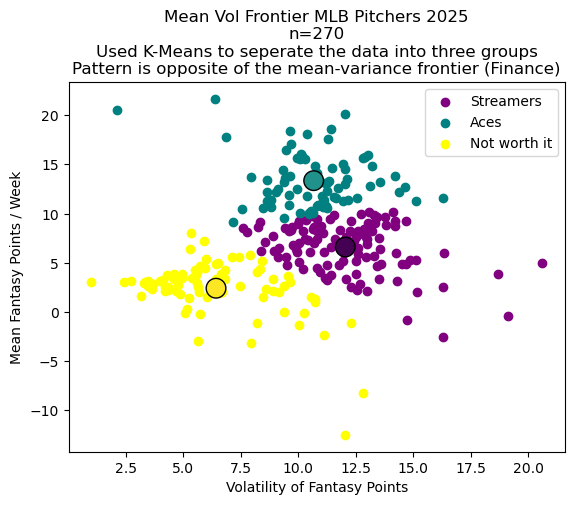

In [644]:
labels = [0,1,2]
labelNames = ["Streamers" , "Aces","Not worth it"]
colors = ["Purple", "Teal","Yellow"]

fig , ax = plt.subplots()
for l in labels:
    sortedPitchers = Pitchers[Pitchers['kmeans label'] == l]
    ax.scatter(sortedPitchers["Vol"] , sortedPitchers["Season Mean"] , c = colors[l], label = labelNames[l])
ax.scatter(means["Vol"] , means["Season Mean"] , c = means.index, s = 200, edgecolors ='black' )
plt.legend()
ax.set(title = "Mean Vol Frontier MLB Pitchers 2025\nn=270\nUsed K-Means to seperate the data into three groups\nPattern is opposite of the mean-variance frontier (Finance)", ylabel = 'Mean Fantasy Points / Week' , xlabel = "Volatility of Fantasy Points")

(array([ 1.,  0.,  1.,  1.,  1.,  1.,  5.,  7., 14., 25., 27., 37., 46.,
        27., 23., 17., 13.,  6.,  9.,  4.,  1.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-1.04  , -0.8972, -0.7544, -0.6116, -0.4688, -0.326 , -0.1832,
        -0.0404,  0.1024,  0.2452,  0.388 ,  0.5308,  0.6736,  0.8164,
         0.9592,  1.102 ,  1.2448,  1.3876,  1.5304,  1.6732,  1.816 ,
         1.9588,  2.1016,  2.2444,  2.3872,  2.53  ,  2.6728,  2.8156,
         2.9584,  3.1012,  3.244 ,  3.3868,  3.5296,  3.6724,  3.8152,
         3.958 ,  4.1008,  4.2436,  4.3864,  4.5292,  4.672 ,  4.8148,
         4.9576,  5.1004,  5.2432,  5.386 ,  5.5288,  5.6716,  5.8144,
         5.9572,  6.1   ,  6.2428,  6.3856,  6.5284,  6.6712,  6.814 ,
       

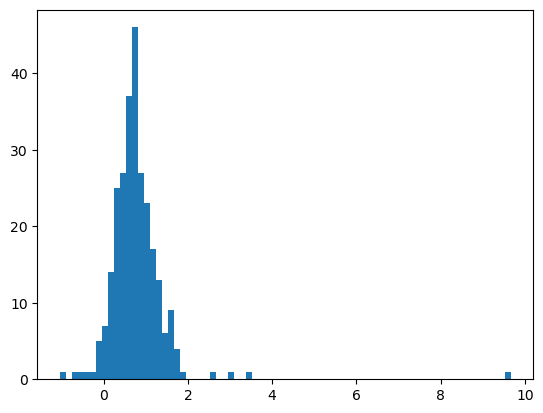

In [257]:
fig , ax = plt.subplots()
ax.hist(x = Pitchers["FP Ratio"], bins = 75)

In [146]:
teamsAPI = statsapi.get('teams', {'sportId': 1})['teams'] 

teams = [team['id'] for team in teamsAPI]


dfs = []
i = 0
for t in teams[26:26]:
    i+=1
    dfI = compare_change_and_pitcher_perf(t)
    dfs.append(dfI)
    print(i)
    time.sleep(30)

MLBPitchingLogFull4 = pd.concat(dfs, ignore_index = True)






1
2
3
4


In [622]:
def _ip_str_to_float(ip_str):
    if not ip_str:
        return 0.0
    whole, _, frac = str(ip_str).partition('.')
    outs = int(whole) * 3 + (int(frac) if frac else 0)
    return outs / 3.0

def _pitching_fantasy_points(stat):
    """Scoring you used earlier; adjust if you like."""

    ip_str = stat.get('inningsPitched', '0')
    whole, _, frac = ip_str.partition('.')
    outs = int(whole) * 3 + (int(frac) if frac else 0)
    
    ip = outs / 3.0

    
    ip   = _ip_str_to_float(stat.get('inningsPitched', '0'))
    er   = int(stat.get('earnedRuns', 0))
    wins = int(stat.get('wins', 0))
    loss = int(stat.get('losses', 0))
    sv   = int(stat.get('saves', 0))
    hld  = int(stat.get('holds', 0))
    k    = int(stat.get('strikeOuts', 0))
    hits = int(stat.get('hits', 0))
    bb   = int(stat.get('baseOnBalls', 0))
    return outs + 5*wins - 5*loss + 5*sv + 3*hld + 1*k - 2*er - 1*hits - 1*bb


def pitching_log_with_context(player_id):
    person = statsapi.get("person", {
        "personId": player_id,
        "hydrate": "stats(group=[pitching],type=[gameLog])"
    })
    splits = person['people'][0]['stats'][0].get('splits', [])
    rows = []
    for s in splits:
        stat = s.get('stat', {})
        gpk  = s['game']['gamePk']
        g    = statsapi.get("game", {"gamePk": gpk})
        box  = g['liveData']['boxscore']['teams']

        side = 'home' if any(p['person']['id'] == player_id for p in box['home']['players'].values()) else 'away'
        opp_side = 'away' if side == 'home' else 'home'
        opp_team_id = g['gameData']['teams'][opp_side]['id']
        opp_team_name = g['gameData']['teams'][opp_side]['name']

        fp = _pitching_fantasy_points(stat)

        rows.append({
            "Date": pd.to_datetime(s['date']),
            "FantasyPoints": fp,
            "HomeAway": 'H' if side == 'home' else 'A',
            "OppTeamId": opp_team_id,
            "OppTeam": opp_team_name
        })
    if not rows:
        return pd.DataFrame(columns=["Date","FantasyPoints","HomeAway","OppTeamId","OppTeam"])
    return pd.DataFrame(rows).sort_values("Date").reset_index(drop=True)

_team_hit_cache = {}

def team_hitting_snapshot(team_id: int, season: int) -> dict:
    key = (team_id, season)
    if key in _team_hit_cache:
        return _team_hit_cache[key]

    try:
        ts = statsapi.get("team_stats", {
            "teamId": team_id,
            "season": season,
            "group": "hitting",
            "stats": "season",      
        })
        stat = ts["stats"][0]["splits"][0]["stat"]

    except Exception:
        t = statsapi.get("team", {
            "teamId": team_id,
            "season": season,
            "hydrate": "stats(group=[hitting],type=[season])"
        })
        team0 = t["teams"][0]
        blocks = team0.get("teamStats") or team0.get("stats")
        if not blocks:
            raise KeyError(f"No team hitting stats available for teamId {team_id}")
        stat = blocks[0]["splits"][0]["stat"]

    gp  = int(stat.get("gamesPlayed", 0)) or 162
    ops = float(stat.get("ops", 0.0))
    so  = int(stat.get("strikeOuts", 0))
    k_per_g = so / gp if gp else 0.0

    out = {"OPS": ops, "K_per_G": k_per_g}
    _team_hit_cache[key] = out
    return out


def next_week_window():
    today = date.today()
    start = today + timedelta(days=(7 - today.weekday()) % 7) 
    end   = start + timedelta(days=6)
    return start, end

def probable_starts(start, end):
    sched = statsapi.schedule(start_date=start.isoformat(), end_date=end.isoformat())
    rows = []
    for g in sched:
        for side in ("home", "away"):
            name = g.get(f"{side}_probable_pitcher")          
            pid  = g.get(f"{side}_probable_pitcher_id")       
            if not name and pid is None:
                continue

            if pid is None and name:
                try:
                    pid = statsapi.lookup_player(name)[0]["id"]
                except Exception:
                    continue  # skip if lookup fails

            opp_side = "away" if side == "home" else "home"
            rows.append({
                "Date": pd.to_datetime(g["game_date"]),
                "PitcherId": int(pid),
                "Pitcher": name or "Unknown",
                "HomeAway": "H" if side == "home" else "A",
                "OppTeamId": g[f"{opp_side}_id"],
                "OppTeam": g[f"{opp_side}_name"],
            })
    return pd.DataFrame(rows).sort_values("Date").reset_index(drop=True)


def build_streamer_board(start: date=None, end: date=None, last_n: int=3,
                         w_recent=0.45, w_opp=0.25, w_home=0.10, w_vol_penalty=0.20,
                         home_bonus_pts=1.0) -> pd.DataFrame:
    if start is None or end is None:
        start, end = next_week_window()
    prob = probable_starts(start, end)
    #print(prob)
    if prob.empty:
        return pd.DataFrame(columns=["Date","Pitcher","Team","OppTeam","HomeAway","RecentFP","SeasonMean",
                                     "Vol","OppOPS","OppK/G","Score"])

    logs = {}
    for pid in prob['PitcherId'].unique():
        logs[pid] = pitching_log_with_context(pid)

    rows = []
    for _, r in prob.iterrows():
        pid = r.PitcherId
        log = logs.get(pid, pd.DataFrame())
        if log.empty:
            continue

        season_mean = log['FantasyPoints'].mean()
        vol = log['FantasyPoints'].std(ddof=0) if len(log) > 1 else 0.0

        recent = log.tail(last_n)['FantasyPoints'].mean() if len(log) >= 1 else 0.0

        season = start.year
        opp = team_hitting_snapshot(int(r.OppTeamId), season)
        opp_ops = opp["OPS"]
        opp_kpg = opp["K_per_G"]

      
        opp_component = (0.720 - opp_ops) * 100 + (opp_kpg - 8.5)

        home_component = home_bonus_pts if r.HomeAway == 'H' else 0.0

        score = (w_recent * recent
                 + w_opp * opp_component
                 + w_home * home_component
                 - w_vol_penalty * vol)

        rows.append({
            "Date": r.Date.date().isoformat(),
            "Pitcher": r.Pitcher,
            "PitcherId": pid,
            "HomeAway": r.HomeAway,
            "OppTeam": r.OppTeam,
            "RecentFP": round(recent, 2),
            "SeasonMean": round(season_mean, 2),
            "Vol": round(vol, 2),
            "OppOPS": round(opp_ops, 3),
            "OppK/G": round(opp_kpg, 2),
            "Score": round(score, 2)
        })

    out = pd.DataFrame(rows).sort_values(["Score","Date"], ascending=[False, True]).reset_index(drop=True)
    return out


def getPitcherPerformanceOneDay(PitcherName , date):
    Date = str(date)
    df = getPitchingLog(PitcherName)
    df['Date'].dt.date
    newdf = df.loc[(df['Date'] == Date)].copy()
    newdf["Excess"] = newdf[PitcherName] - newdf[f'{PitcherName} Rolling Mean']
    try:
        x = newdf["Excess"].values[0]
    except:
        x = pd.NA
        return x
    else:
        x = round(newdf["Excess"].values[0],2)
        return x 
        
    


In [285]:
full_Board = build_streamer_board(date(2025,8,14), date(2025,8,16))
top10 = full_Board.head(10)
top10


         Date  PitcherId            Pitcher HomeAway  OppTeamId  \
0  2025-08-14     608372    Tomoyuki Sugano        H        136   
1  2025-08-14     699134  Eduardo Rodriguez        A        115   
2  2025-08-14     687134    Bradley Blalock        H        109   
3  2025-08-14     641927        Bailey Ober        H        116   
4  2025-08-14     693821        Bryce Elder        A        121   
5  2025-08-14     673540        Kodai Senga        H        144   
6  2025-08-14     666200      Jesús Luzardo        A        120   
7  2025-08-14     669373       Tarik Skubal        A        142   
8  2025-08-14     665795     Edward Cabrera        A        114   
9  2025-08-14     676440       Tanner Bibee        H        146   
10 2025-08-14     571510       Matthew Boyd        A        141   
11 2025-08-14     453286       Max Scherzer        H        112   
12 2025-08-14     688138        Logan Evans        A        110   
13 2025-08-14     695418          Brad Lord        H        14

,Date,Pitcher,PitcherId,HomeAway,OppTeam,RecentFP,SeasonMean,Vol,OppOPS,OppK/G,Score
0,2025-08-14,Edward Cabrera,665795,A,Cleveland Guardians,22.67,12.35,10.97,0.678,8.18,8.97
1,2025-08-14,Jesús Luzardo,666200,A,Washington Nationals,21.00,11.54,15.94,0.697,7.83,6.67
2,2025-08-16,Jason Alexander,669920,H,Baltimore Orioles,18.67,6.00,13.53,0.707,8.65,6.16
3,2025-08-14,Tomoyuki Sugano,608372,H,Seattle Mariners,17.33,8.68,10.46,0.728,8.89,5.71
4,2025-08-15,Noah Cameron,702070,H,Chicago White Sox,13.33,13.25,9.09,0.667,8.39,5.58
5,2025-08-16,Bryan Woo,693433,A,New York Mets,16.67,15.83,9.95,0.732,8.02,5.09
6,2025-08-14,Tarik Skubal,669373,A,Minnesota Twins,15.33,20.09,11.75,0.707,8.27,4.82
7,2025-08-15,Luis Castillo,622491,A,New York Mets,16.00,11.79,10.79,0.732,8.02,4.62
8,2025-08-16,Taijuan Walker,592836,A,Washington Nationals,12.67,5.84,7.75,0.697,7.83,4.56
9,2025-08-16,Michael Lorenzen,547179,H,Chicago White Sox,12.33,7.61,12.16,0.667,8.39,4.52


In [349]:
board = full_Board.merge(Pitchers[["Pitcher","Type"]] , on = "Pitcher")
board[board["Type"] == "Streamer"].head(10)

,Date,Pitcher,PitcherId,HomeAway,OppTeam,RecentFP,SeasonMean,Vol,OppOPS,OppK/G,Score,Type
2,2025-08-09,Nick Martinez,607259,A,Pittsburgh Pirates,12.67,8.31,11.60,0.650,8.64,5.17,Streamer
9,2025-08-09,Logan Evans,688138,H,Tampa Bay Rays,9.00,7.80,9.65,0.716,8.52,2.33,Streamer
10,2025-08-09,Sean Burke,680732,H,Cleveland Guardians,7.00,6.61,11.19,0.678,8.18,1.98,Streamer
11,2025-08-09,Jack Perkins,678022,A,Baltimore Orioles,6.00,7.10,8.14,0.708,8.59,1.39,Streamer
12,2025-08-09,Colin Rea,607067,A,St. Louis Cardinals,7.00,8.46,10.42,0.704,7.75,1.28,Streamer
13,2025-08-09,Charlie Morton,450203,H,Los Angeles Angels,6.00,5.20,11.73,0.715,9.70,0.88,Streamer
14,2025-08-09,Ryan Gusto,687473,A,Atlanta Braves,5.00,6.08,9.74,0.711,8.70,0.58,Streamer
18,2025-08-09,Sandy Alcantara,645261,A,Atlanta Braves,3.33,3.30,11.81,0.711,8.70,-0.59,Streamer
20,2025-08-09,Bailey Ober,641927,H,Kansas City Royals,1.67,6.11,10.83,0.691,6.87,-1.00,Streamer
23,2025-08-09,Erick Fedde,607200,H,Miami Marlins,1.33,2.87,12.40,0.713,7.88,-1.76,Streamer


In [ ]:
# TESTING

In [416]:
boardAug8 = full_Board.merge(Pitchers[["Pitcher","Type"]] , on = "Pitcher")
boardAug8 = boardAug8[boardAug8["Type"] == "Streamer"]
boardAug8

,Date,Pitcher,PitcherId,HomeAway,OppTeam,RecentFP,SeasonMean,Vol,OppOPS,OppK/G,Score,Perfromance,Type
2,2025-08-09,Nick Martinez,607259,A,Pittsburgh Pirates,12.67,8.31,11.60,0.650,8.64,5.17,13.69,Streamer
9,2025-08-09,Logan Evans,688138,H,Tampa Bay Rays,9.00,7.80,9.65,0.716,8.52,2.33,4.79,Streamer
10,2025-08-09,Sean Burke,680732,H,Cleveland Guardians,7.00,6.61,11.19,0.678,8.18,1.98,-6.61,Streamer
11,2025-08-09,Jack Perkins,678022,A,Baltimore Orioles,6.00,7.10,8.14,0.708,8.59,1.39,10.9,Streamer
12,2025-08-09,Colin Rea,607067,A,St. Louis Cardinals,7.00,8.46,10.42,0.704,7.75,1.28,13.54,Streamer
13,2025-08-09,Charlie Morton,450203,H,Los Angeles Angels,6.00,5.20,11.73,0.715,9.70,0.88,-7.2,Streamer
14,2025-08-09,Ryan Gusto,687473,A,Atlanta Braves,5.00,6.08,9.74,0.711,8.70,0.58,2.92,Streamer
18,2025-08-09,Sandy Alcantara,645261,A,Atlanta Braves,3.33,3.30,11.81,0.711,8.70,-0.59,-10.3,Streamer
20,2025-08-09,Bailey Ober,641927,H,Kansas City Royals,1.67,6.11,10.83,0.691,6.87,-1.00,3.89,Streamer
23,2025-08-09,Erick Fedde,607200,H,Miami Marlins,1.33,2.87,12.40,0.713,7.88,-1.76,4.13,Streamer


In [442]:
boardAug8["Performance"] = boardAug8[["Pitcher", "Date"]].apply(
    lambda row: getPitcherPerformanceOneDay(row["Pitcher"], row["Date"]),
    axis=1)
boardAug8

,Date,Pitcher,PitcherId,HomeAway,OppTeam,RecentFP,SeasonMean,Vol,OppOPS,OppK/G,Score,Perfromance,Type,Performance
2,2025-08-09,Nick Martinez,607259,A,Pittsburgh Pirates,12.67,8.31,11.60,0.650,8.64,5.17,13.69,Streamer,13.69
9,2025-08-09,Logan Evans,688138,H,Tampa Bay Rays,9.00,7.80,9.65,0.716,8.52,2.33,4.79,Streamer,4.79
10,2025-08-09,Sean Burke,680732,H,Cleveland Guardians,7.00,6.61,11.19,0.678,8.18,1.98,-6.61,Streamer,-6.61
11,2025-08-09,Jack Perkins,678022,A,Baltimore Orioles,6.00,7.10,8.14,0.708,8.59,1.39,10.90,Streamer,10.90
12,2025-08-09,Colin Rea,607067,A,St. Louis Cardinals,7.00,8.46,10.42,0.704,7.75,1.28,13.54,Streamer,13.54
13,2025-08-09,Charlie Morton,450203,H,Los Angeles Angels,6.00,5.20,11.73,0.715,9.70,0.88,-7.20,Streamer,-7.20
14,2025-08-09,Ryan Gusto,687473,A,Atlanta Braves,5.00,6.08,9.74,0.711,8.70,0.58,2.92,Streamer,2.92
18,2025-08-09,Sandy Alcantara,645261,A,Atlanta Braves,3.33,3.30,11.81,0.711,8.70,-0.59,-10.30,Streamer,-10.30
20,2025-08-09,Bailey Ober,641927,H,Kansas City Royals,1.67,6.11,10.83,0.691,6.87,-1.00,3.89,Streamer,3.89
23,2025-08-09,Erick Fedde,607200,H,Miami Marlins,1.33,2.87,12.40,0.713,7.88,-1.76,4.13,Streamer,4.13


[Text(0.5, 0, 'Pitcher Score'),
 Text(0, 0.5, 'Excess over mean'),
 Text(0.5, 1.0, 'Aug 8th Prediction Results\n r= 0.63 , p = 0.02')]

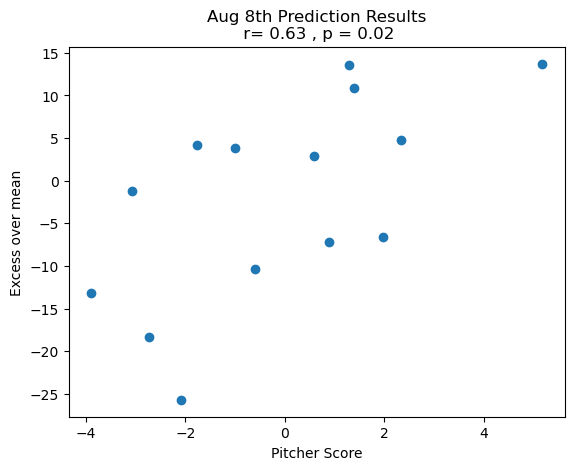

In [426]:
fig , ax = plt.subplots()
ax.scatter(boardAug8["Score"] , boardAug8["Perfromance"])

correlation, p_value = pearsonr(boardAug8["Score"],  boardAug8["Perfromance"])

ax.set(xlabel = "Pitcher Score", ylabel = "Excess over mean", title = f"Aug 8th Prediction Results\n r= {round(correlation,2)} , p = {round(p_value,2)}")




In [448]:
def testDate(date):
    full_Board = build_streamer_board(date, date)
    boardDay = full_Board.merge(Pitchers[["Pitcher","Type"]] , on = "Pitcher")
    boardDay = boardDay[boardDay["Type"] == "Streamer"]

    boardDay["Performance"] = boardDay[["Pitcher", "Date"]].apply(
    lambda row: getPitcherPerformanceOneDay(row["Pitcher"], row["Date"]),
    axis=1)
    
    
    return boardDay




In [ ]:
dateLists = []
from datetime import date, timedelta
import time

for x in range(7,10):
    x+=1
    dateLists.append(date(2025,8,x))
    
dfs = []
for date in dateLists:
    dfi = testDate(date)
    time.sleep(10)
    dfs.append(dfi)
lastTwoWeeks = pd.concat(dfs)


In [568]:
dfList = [aug1to7 , dfs[0]]
aug1to8 = pd.concat(dfList)
aug1to8.dropna(inplace = True)
def colors(ha):
    if ha == "H":
        return "Blue"
    else:
        return "Yellow"
aug1to8['color'] = aug1to8["HomeAway"].apply(colors)
    

[Text(0.5, 0, 'Pitcher Score'),
 Text(0, 0.5, 'Excess over mean'),
 Text(0.5, 1.0, 'Aug 1st-Aug7th Prediction Results\n r= 0.63 , p = 0.0')]

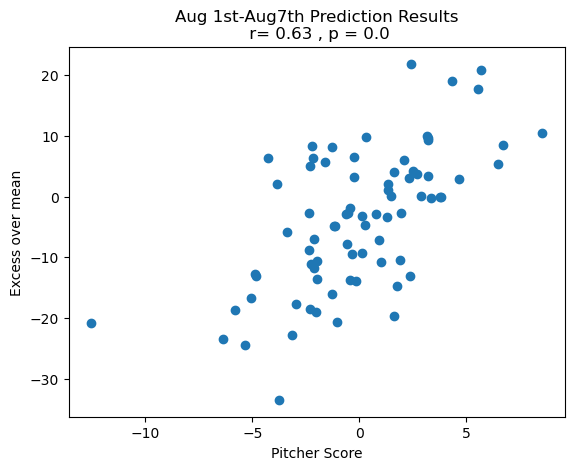

In [572]:
fig , ax = plt.subplots()
ax.scatter(aug1to8["Score"] , aug1to8["Performance"] )

correlation, p_value = pearsonr(aug1to8["Score"],  aug1to8["Performance"])

ax.set(xlabel = "Pitcher Score", ylabel = "Excess over mean", title = f"Aug 1st-Aug7th Prediction Results\n r= {round(correlation,2)} , p = {round(p_value,2)}")



In [614]:
from datetime import date, timedelta
import time
def buildBoard(DATE)
    full_Board = build_streamer_board(DATE, DATE)
    board = full_Board.merge(Pitchers[["Pitcher","Type"]] , on = "Pitcher")
    board[board["Type"] == "Streamer"].head(10)

buildBoard(date(2025, 8, 17))

,Date,Pitcher,PitcherId,HomeAway,OppTeam,RecentFP,SeasonMean,Vol,OppOPS,OppK/G,Score,Type
2,2025-08-17,Will Warren,701542,A,St. Louis Cardinals,17.33,9.28,12.05,0.704,7.76,5.61,Streamer
4,2025-08-17,Yu Darvish,506433,A,Los Angeles Dodgers,20.00,6.00,15.12,0.771,8.51,4.70,Streamer
9,2025-08-17,Jeffrey Springs,605488,H,Los Angeles Angels,12.00,9.88,13.04,0.713,9.73,3.37,Streamer
10,2025-08-17,Logan Allen,671106,H,Atlanta Braves,11.33,7.35,10.61,0.711,8.69,3.35,Streamer
12,2025-08-17,Chris Paddack,663978,A,Minnesota Twins,10.33,6.38,13.26,0.706,8.26,2.29,Streamer
14,2025-08-17,Davis Martin,663436,A,Kansas City Royals,6.67,6.83,9.48,0.691,6.86,1.42,Streamer
15,2025-08-17,Dean Kremer,665152,A,Houston Astros,8.33,9.46,11.14,0.726,7.78,1.19,Streamer
16,2025-08-17,José Soriano,667755,A,Athletics,9.33,9.24,13.91,0.751,8.53,0.65,Streamer
20,2025-08-17,Erick Fedde,607200,A,Cleveland Guardians,1.33,2.87,12.40,0.679,8.18,-0.94,Streamer
21,2025-08-17,Clay Holmes,605280,H,Seattle Mariners,0.67,9.17,8.16,0.727,8.85,-1.32,Streamer
